# Link functions

[Tom Wallis](http://www.tomwallis.info) and [Philipp Berens](http://philippberens.wordpress.com/)

The University of Tübingen

In [1]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import numpy as np
import scipy as sp
import pandas as pd
import patsy
import seaborn as sns
import statsmodels.formula.api as smf
import statsmodels.api as sm
import matplotlib.pyplot as plt
import itertools

%matplotlib inline

sns.set_style("white")

# Link functions

Recall from the lecture that the general form of the GLM is 

$y = f(\mathbf{X} \beta) + \epsilon$

All the models we've considered up until now are *linear* models: the *link function* $f()$ is the identity --- that is, it doesn't change $\mathbf{X} \beta$ at all, and the noise $\epsilon$ is assumed to be Gaussian.

But for many response variables, linear predictions don't make a lot of sense. Consider one of the example datasets we've given you: "g-forces" (from [here](http://www.statsci.org/data/general/gforces.html)). From the description:

*Military pilots sometimes black out when their brains are deprived of oxygen due to G-forces during violent maneuvers.* 

<img src="data/topgun.jpg">

*Glaister and Miller (1990) produced similar symptoms by exposing volunteers’ lower bodies to negative air pressure, likewise decreasing oxygen to the brain. The data lists the subjects' ages and whether they showed syncopal blackout related signs (pallor, sweating, slow heartbeat, unconsciousness) during an 18 minute period.*




So Glaister and Miller (1990) wanted to know whether the propensity to black out was related to the subject's age. They tested this in 8 people. Let's import the data:

In [2]:
gf = pd.read_csv('./data/gforces.txt', sep='\t')
# make all columns lower case:
gf.columns = [c.lower() for c in gf.columns]
print(gf)

  subject  age  signs
0      JW   39      0
1      JM   42      1
2      DT   20      0
3      LK   37      1
4      JK   20      1
5      MK   21      0
6      FP   41      1
7      DG   52      1


Note that the response variable we're trying to predict (`signs`) takes on *only* one of two possible values: either the subject showed blackout signs (y = 1) or did not (y = 0). 

*Aside: the numerical values 0 and 1 are used by convention and for mathematical convenience. Think of it like "the presence of somthing (1) and the absence of something (0)"*.

What happens if we fit an ordinary (Gaussian error) linear regression to these data?

In [3]:
gf

,subject,age,signs
0,JW,39,0
1,JM,42,1
2,DT,20,0
3,LK,37,1
4,JK,20,1
5,MK,21,0
6,FP,41,1
7,DG,52,1


In [4]:
fit_lm = smf.glm('signs ~ age', gf).fit()
print(fit_lm.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                  signs   No. Observations:                    8
Model:                            GLM   Df Residuals:                        6
Model Family:                Gaussian   Df Model:                            1
Link Function:               identity   Scale:                         0.23433
Method:                          IRLS   Log-Likelihood:                -4.3968
Date:                Sun, 12 Feb 2023   Deviance:                       1.4060
Time:                        17:52:27   Pearson chi2:                     1.41
No. Iterations:                     3   Pseudo R-squ. (CS):             0.2501
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.0998      0.540     -0.185      0.8

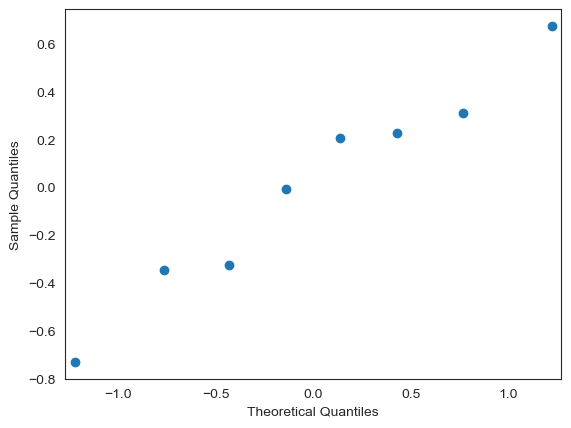

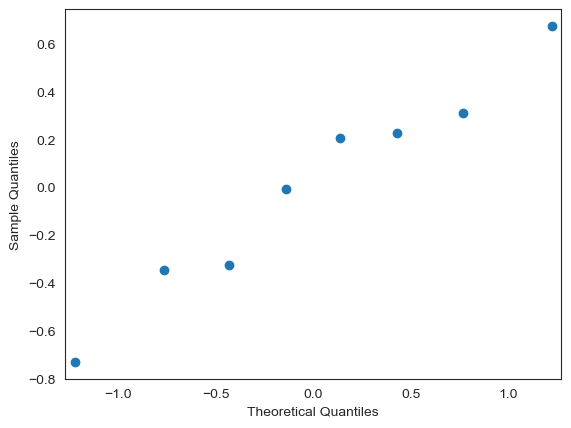

In [5]:
sm.graphics.qqplot(fit_lm.resid_pearson)

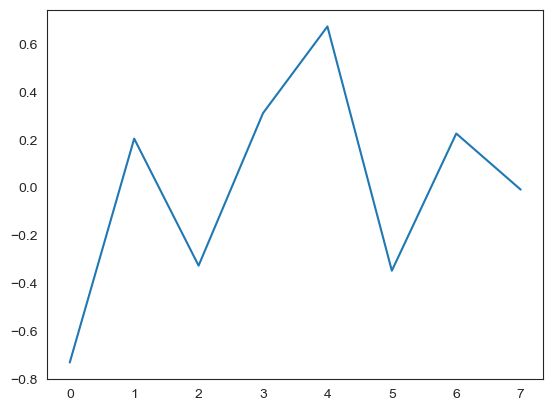

In [6]:
plt.plot(fit_lm.resid_pearson)

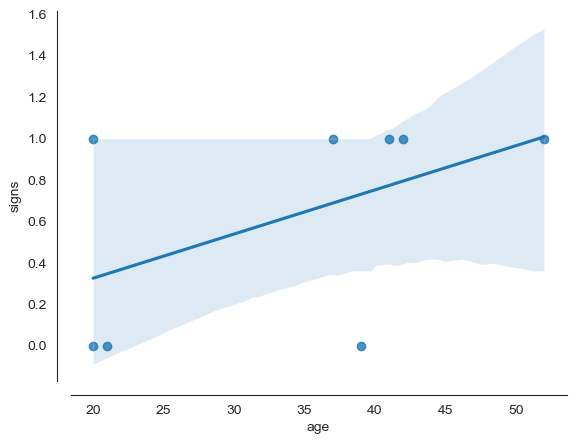

In [7]:
# Let's have a look at the model predictions
sns.regplot(x='age', y='signs', data=gf)
sns.despine(offset=10);

Notice how the data are only `0s` or `1s`, but that our model can happily predict values outside this range. Moreover, our model expects the errors to be Gaussian, and they clearly won't be. Therefore, this linear model is not appropriate for these data.

What we want instead is to change the link function $f()$ from the identity (i.e. our prediction is just $\mathbf{X} \beta$ with Gaussian errors) to something more appropriate for the data we have. We are going to *transform* the linear predictor into a more appropriate range, by changing the link function.

Our linear predictor can theoretically range from `-inf` to `+inf`. We want something that maps this range into the range 0--1. There are a number of options, but the most common is the [logistic function](http://mathworld.wolfram.com/SigmoidFunction.html):

$y = \frac{1}{1 + e^{-x}}$

Let's plot what this does:

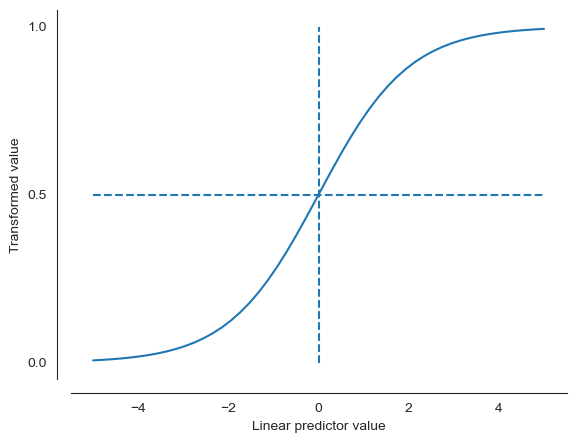

In [8]:
def logit(x): 
    return(1. / (1. + np.exp(-x)))

x = np.linspace(-5, 5)  # imagine this is the linear predictor (inner product of X and beta)
y = logit(x)
plt.plot(x, y)
sns.despine(offset=10)
plt.vlines(0, 0, 1, linestyles='--')
plt.hlines(0.5, -5, 5, linestyles='--')
plt.yticks([0, 0.5, 1])
plt.xlabel('Linear predictor value')
plt.ylabel('Transformed value');

The `logit` transform allows us to map our linear predictor into a bounded range. Note also that when the linear predictor is zero, the logit is 0.5. 

How can we now use this transformed value to predict dichotomous responses?

### Binomial distribution

Since the response variable is dichotomous (either "shows signs" or "does not show signs"), an appropriate probability distribution to describe the data is the [*binomial distribution*](http://www.wolframalpha.com/input/?i=binomial+distribution). Just as the Normal distribution returns a probability density over a continuous dimension given a mean and standard deviation, the binomial distribution gives a probability mass over a discrete dimension (number of "successes"), given a number of "trials" and a probability of success, $p$ (note since $p$ is a probability, it can have any value from 0 to 1). 

The most common example used to demonstrate the binomial distribution is coin flipping. Imagine we have a fair coin ($p = 0.5$) and we flip it 50 times. How many heads ("successes") would we expect? The binomial distribution can tell us.

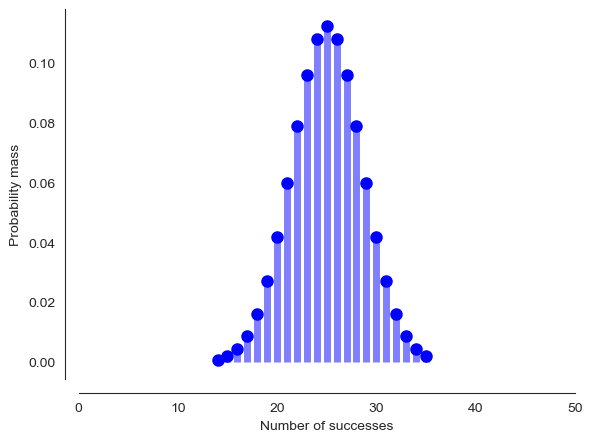

In [9]:
# code hacked from here: http://docs.scipy.org/doc/scipy-0.14.0/reference/generated/scipy.stats.binom.html
n, p = 50, 0.5
fig, ax = plt.subplots(1, 1)
x = np.arange(sp.stats.distributions.binom.ppf(0.001, n, p), 
              sp.stats.distributions.binom.ppf(0.999, n, p))
ax.plot(x, sp.stats.distributions.binom.pmf(x, n, p), 'bo', ms=8, label='binom pmf')
ax.vlines(x, 0, sp.stats.distributions.binom.pmf(x, n, p), colors='b', lw=5, alpha=0.5)
sns.despine(offset=10);
plt.xlabel('Number of successes')
plt.xlim(0, 50)
plt.ylabel('Probability mass');

Now imagine we have a trick coin, which comes up heads 90% of the time. How many heads do we expect now?

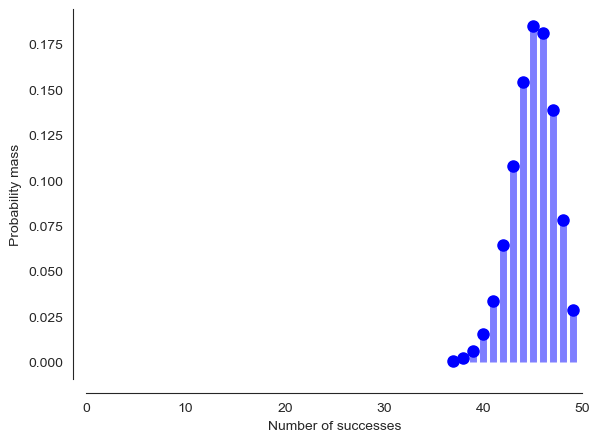

In [10]:
n, p = 50, 0.9
fig, ax = plt.subplots(1, 1)
x = np.arange(sp.stats.distributions.binom.ppf(0.001, n, p), 
              sp.stats.distributions.binom.ppf(0.999, n, p))
ax.plot(x, sp.stats.distributions.binom.pmf(x, n, p), 'bo', ms=8, label='binom pmf')
ax.vlines(x, 0, sp.stats.distributions.binom.pmf(x, n, p), colors='b', lw=5, alpha=0.5)
sns.despine(offset=10);
plt.xlabel('Number of successes')
plt.xlim(0, 50)
plt.ylabel('Probability mass');

So you can see that changing $p$ changes the number of successes we expect from a given number of trials (equivalently, the chance of a success on any one trial).

Now, by assuming that our response distribution is binomially distributed, we can estimate the expected probability of showing blackout signs as a function of age. To do this, we use the logit transformed linear predictor as our estimate of $p$ in the binomial distribution. 

We can use statsmodel's `glm` function to find the regression weights that maximise the likelihood of the observed data, assuming that the data come from a binomial distribution:

In [11]:
fit = smf.glm('signs ~ age', 
              data=gf, 
              family=sm.families.Binomial(sm.families.links.logit())).fit()
# note we don't have to specify the logit link above, since it's the default for the binomial distribution.

print(fit.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                  signs   No. Observations:                    8
Model:                            GLM   Df Residuals:                        6
Model Family:                Binomial   Df Model:                            1
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -4.2173
Date:                Sun, 12 Feb 2023   Deviance:                       8.4345
Time:                        17:52:28   Pearson chi2:                     7.42
No. Iterations:                     4   Pseudo R-squ. (CS):             0.2357
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -2.9209      2.647     -1.104      0.2

We get a summary table with regression coefficients as before. Note that a few things have changed: in particular, see that the `Model Family` is now "Binomial", and the `Link Function` is the logit. This is also called a **logistic regression**, because it uses the logit link function.

How do the regression coefficients above compare to the linear, Gaussian model we fit before?

In [12]:
print(fit_lm.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                  signs   No. Observations:                    8
Model:                            GLM   Df Residuals:                        6
Model Family:                Gaussian   Df Model:                            1
Link Function:               identity   Scale:                         0.23433
Method:                          IRLS   Log-Likelihood:                -4.3968
Date:                Sun, 12 Feb 2023   Deviance:                       1.4060
Time:                        17:52:28   Pearson chi2:                     1.41
No. Iterations:                     3   Pseudo R-squ. (CS):             0.2501
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.0998      0.540     -0.185      0.8

You can see the regression coefficients are totally different numbers. However, our *design matrix* $\mathbf{X}$ didn't change: it's still a column of ones and a column of `age`. The reason the coefficients are different is because in the logistic regression, the beta weights pass through the link function to give a prediction for the response variable. 

Let's run through what the regression coefficients mean in the logistic regression (`fit`).

The `Intercept` is the value of the *linear predictor* (note: not the response!) when age = 0. In this case, we can't observe an age of zero, so the intercept is not very meaningful 

*Aside: To make the intercept more interpretable, we could centre the `age` variable by subtracting its mean -- this would make the intercept equal the linear predictor value when age is at its mean in the data. We could do this within the Patsy formula by writing `signs ~ center(age)`. We will avoid doing this here for simplicity.*

The `age` coefficient tells us the change in the *linear predictor* for an increase in age of one year.

To work out what these mean for the *response* value, we need to pass them through the logit function. As an example, let's consider the prediction for the chance a 28 year old person would show blackout signs.

In [13]:
age = 28
linear_predictor = fit.params[0] + fit.params[1]*age
linear_predictor

0.03850819277904893

In [14]:
pred = logit(linear_predictor)
pred

0.5096258587239797

So our prediction for a 28 year old is that they would have about a 51% chance to black out. We can also compute this using the `predict` method of the fit object. Let's do that for a 65 year old:

In [15]:
fit.predict(exog={'age':65})

0    0.981092
dtype: float64

Our model predicts that a 65 year old would have a 98.1% chance of blacking out. What would happen if we tried making similar predictions from the (inappropriate) linear model?

In [16]:
fit_lm.predict(exog={'age': 65})

0    1.285853
dtype: float64

The linear model predicts a value of 1.28 for a 65 year old -- which makes no sense.

## Plotting model predictions

Let's plot our model predictions for the chance of blacking out against the data.

In [17]:
# define expand grid function:
def expand_grid(data_dict):
    """ A port of R's expand.grid function for use with Pandas dataframes.
    
    from http://pandas.pydata.org/pandas-docs/stable/cookbook.html?highlight=expand%20grid
    
    """
    rows = itertools.product(*data_dict.values())
    return pd.DataFrame.from_records(rows, columns=data_dict.keys())


# build a new matrix with expand grid:
preds = expand_grid({'age': np.linspace(10, 80, num=100)})  # put a line of ages in, to plot a smooth curve.
preds['yhat'] = fit.predict(preds)

# add to data:
merged = gf.append(preds)
merged.tail()

,subject,age,signs,yhat
95,NaN,77.171717,NaN,0.994704
96,NaN,77.878788,NaN,0.995084
97,NaN,78.585859,NaN,0.995436
98,NaN,79.292929,NaN,0.995763
99,NaN,80.000000,NaN,0.996067


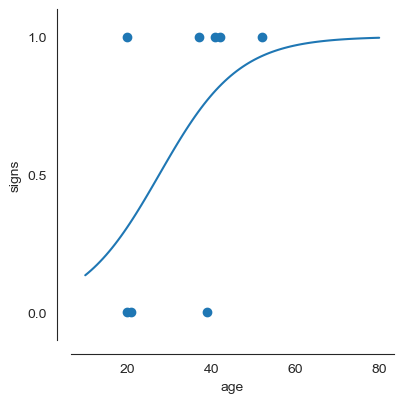

In [18]:
g = sns.FacetGrid(merged, height=4)
g.map(plt.plot, 'age', 'yhat')  # plot model predictions
g.map(plt.scatter, 'age', 'signs')
sns.despine(offset=10);
plt.ylim([-.1, 1.1])
plt.yticks([0, 0.5, 1]);

# Logistic regression with categorical and continuous predictors

We can extend the design matrix to include any combination of continuous and categorical predictors as in the previous lectures, but using the logistic link function to predict 0--1 data. 

To demonstrate this I will use a dataset from a psychophysical experiment [(Wallis & Bex, 2012)](http://www.journalofvision.org/content/12/7/6). In this experiment, three observers detected the location of a target embedded in a natural image in a forced-choice paradigm. The target (a circular patch of texture) could appear above, right, below or left of the observer's fixation point. The stimuli looked a bit like this:

<img src='data/stimulus.png'>

The image above contains 12 patches of texture (three on each cardinal meridian relative to the fixation point). Note that in the actual experiment, only one patch was shown at one of the four possible target locations.

After each trial, the observer responded with one of four buttons. This is a four-alternative forced-choice (4AFC) task: if the observer could not see the target at all, average performance should be 25% correct. 

We varied, among other things, the size of the patch and the eccentricity (distance from fixation). Let's import the data and have a look:

In [19]:
nat_ims = pd.read_csv('./data/psychophysics.txt', sep='\t')
# columns to lowercase:
nat_ims.columns = [c.lower() for c in nat_ims.columns]
nat_ims.head()

,observer,trialnum,blocknum,eccent,patchsize,correct,targetloc,responseloc,imageori
0,TW,1.0,1.0,2.0,-0.391207,1.0,u,u,0CW
1,TW,2.0,1.0,2.0,-0.391207,1.0,d,d,270CW
2,TW,3.0,1.0,2.0,-0.505150,0.0,d,r,180CW
3,TW,4.0,1.0,2.0,-0.505150,1.0,l,l,270CW
4,TW,5.0,1.0,2.0,-0.505150,1.0,u,u,0CW


Each row in the dataset corresponds to one trial. We are told the observer, trial and block numbers, the eccentricity, the log patch size (log 10 pixels), the target location (relative to fixation), the response location (relative to fixation) and the orientation of the image relative to its veridical orientation.

Finally, the column `correct` tells us whether the observer got the trial correct (`1`) or incorrect (`0`). 


How many trials did each observer do?

In [20]:
nat_ims.groupby(['observer']).size()

observer
N1    17200
PB    16918
TW    16932
dtype: int64

So each observer did about 17000 trials. Because ~50,000 observations is quite a lot, the plotting takes a while. For this reason I'm going to take a random subsample of the data first.

In [21]:
np.random.seed(12345)  # seed rng so these results are reproducible.
rows = np.random.choice(nat_ims.index, size=5000, replace=False)
dat = nat_ims.loc[rows].copy() 
dat.groupby(['observer', 'eccent']).size()

observer  eccent
N1        2.0       558
          4.0       597
          8.0       510
PB        2.0       527
          4.0       547
          8.0       571
TW        2.0       538
          4.0       570
          8.0       582
dtype: int64

How can we predict performance across all trials? This is another example of a binomial dataset, which we can model using logistic regression. 

We can plot some of the data and fit models in one step using Seaborn:

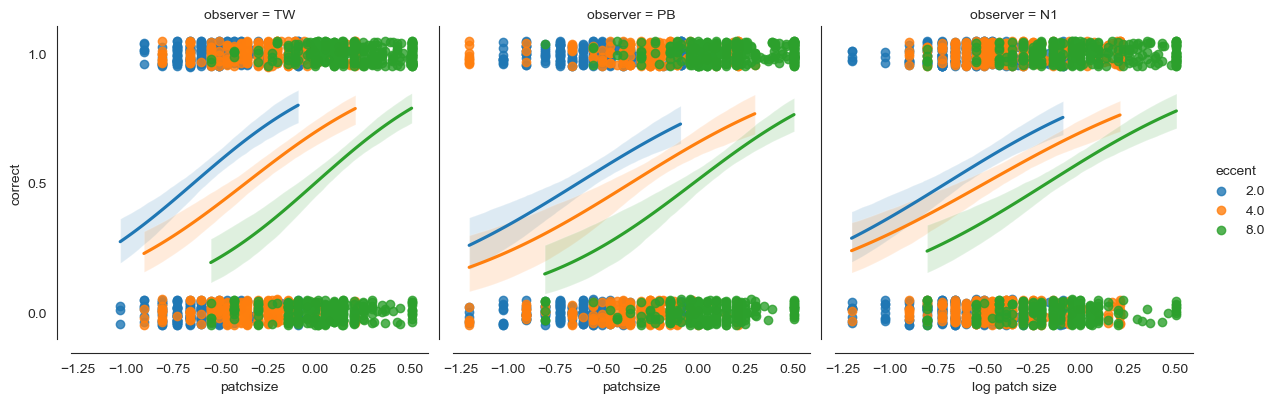

In [22]:
sns.lmplot(x='patchsize', 
           y='correct', 
           data=dat,
           hue='eccent',
           col='observer',
           logistic=True,
           y_jitter=.05,
           height=4)
sns.despine(offset=10)
g.fig.subplots_adjust(wspace=0.5)
plt.xlabel('log patch size')
plt.ylabel('Proportion correct')
plt.yticks([0, 0.5, 1]);

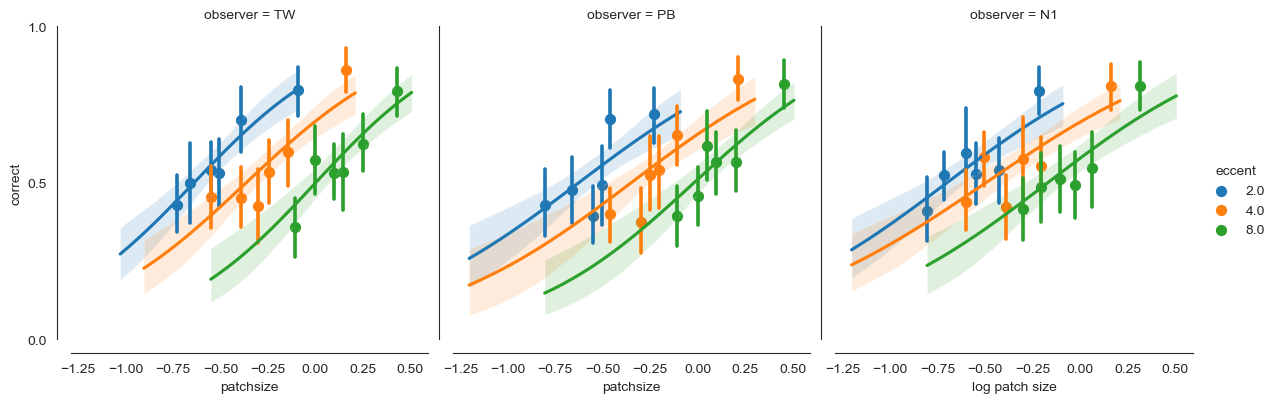

In [23]:
# the data get easier to see if we bin trials along the x-axis:
sns.lmplot(x='patchsize', 
           y='correct', 
           data=dat,
           hue='eccent',
           col='observer',
           logistic=True,
           x_bins=6,
           height=4)
sns.despine(offset=10)
g.fig.subplots_adjust(wspace=0.5)
plt.xlabel('log patch size')
plt.ylabel('Proportion correct')
plt.yticks([0, 0.5, 1]);

Now let's fit a logistic regression using Statsmodels that considers the influence of patchsize and eccentricity, where here we will code eccentricity as a categorical variable with 3 levels.

Note that for simplicity here, I will just fit to all the data (pooled across observers). This should be analysed as a repeated measures design (the conditions are nested within observers), but this is beyond the scope of this course.

In [24]:
fit = smf.glm('correct ~ patchsize + C(eccent)', 
              data=nat_ims, 
              family=sm.families.Binomial()).fit()
# note we don't have to specify the logit link above, since it's the default for the binomial distribution.

print(fit.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                correct   No. Observations:                51050
Model:                            GLM   Df Residuals:                    51046
Model Family:                Binomial   Df Model:                            3
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -33392.
Date:                Sun, 12 Feb 2023   Deviance:                       66784.
Time:                        17:52:44   Pearson chi2:                 5.10e+04
No. Iterations:                     5   Pseudo R-squ. (CS):            0.06509
Covariance Type:            nonrobust                                         
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept            1.2857      0.025  

What do the coefficients mean?

The intercept is the value of the linear predictor when the target is at 2 degrees from fixation and log patchsize is zero. In this case, the model predicts performance will be `logit(1.2857)`, about 78% correct.

The two coefficients for eccent show the offset applied to the linear predictor when the eccentricity is 4 or 8 degrees, relative to an eccentricity of 2. So when log patch size is zero, we predict the performance at 4 degrees to be `logit(1.2857 -0.5116)`, about 68% correct. Similarly, a patch of log size zero presented 8 degrees from fixation would be expected to yield 51% correct. 

The same sized patch is harder to detect, the further away from fixation it is presented.

Finally, the `patchsize` coefficient shows the change in the linear predictor for a one-unit (i.e. 1 log unit change) in the size of the patch. At 2 degrees, a patch of log size 0 yields 78% correct (see above); if the patch was log size 1 it would be expected to yield `logit(1.2857 + 2.0228*1)` or 96% correct, on average.

## Conclusion: Binomial models

The GLM can be used to model a dichotomous response variable by assuming that variable is distributed according to a binomial distribution. Dichotomous response variables are found often in neuroscience and psychology: whenever we talk about "percent correct" or similar variables (like the psychophysical dataset above). 

To do this, we "squash" the linear predictor through the `logit` function, which gives it bounds between 0 and 1.This squashing procedure and binomial family is an example of changing the identity link function and the error model. It's what makes the GLM "generalised". 

Note that nothing changed about how we construct or interpret the design matrix for our model: everything we've learned about design matrices still apply.

# Poisson regression

It's common in neuroscience to measure the spiking activity of neurons. Spikes over time can be thought of as "events", and thus the number of spikes in a time interval as event counts. 

Counts are discrete and non-negative - thus modeling their distribution requires again a different type of GLM. Luckily, we can again achieve that by changing the link function.

As a very brief example, we consider a neuron recorded from V1 while showing a grating with two different orientations at two different contrasts. What type of design do we have here?

In [25]:
spk = pd.read_csv('./data/neuron2.txt', sep='\t',index_col=False)

In [26]:
spk.head()

,spikes,contrast,orientation
0,3.0,1.0,0.0
1,6.0,1.0,0.0
2,3.0,1.0,0.0
3,3.0,1.0,0.0
4,6.0,1.0,0.0


In [27]:
spk.contrast.unique(), spk.orientation.unique()

(array([ 1., 10.]), array([ 0., 90.]))

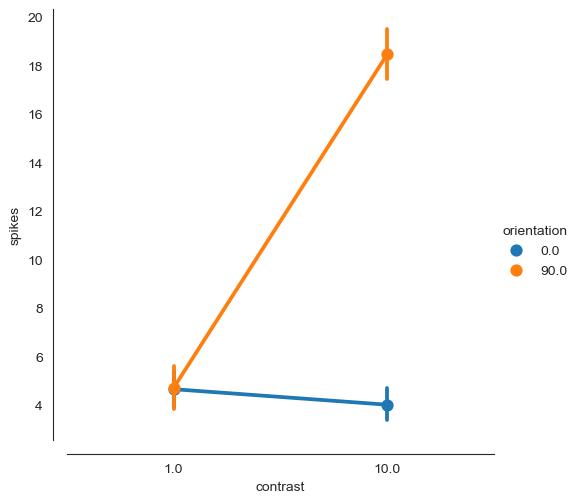

In [29]:
sns.catplot(x="contrast", y="spikes", hue="orientation", data=spk, kind='point')
sns.despine(offset=10);

What type of effects would you assume when we fit a GLM with appropriate link function?

The correct model family for count data is the Poisson family, with the log link function

$X\beta = \ln(\mu)$

or conversly

$\mu = \exp(X\beta)$

This takes care of two things
* The output of the rhs is nonnegative
* The variance of the output increases with the input, as in count data

In [30]:
spk

,spikes,contrast,orientation
0,3.0,1.0,0.0
1,6.0,1.0,0.0
2,3.0,1.0,0.0
3,3.0,1.0,0.0
4,6.0,1.0,0.0
...,...,...,...
151,23.0,10.0,90.0
152,16.0,10.0,90.0
153,22.0,10.0,90.0
154,26.0,10.0,90.0


In [31]:
fit = smf.glm('spikes ~ contrast * orientation', 
              data=spk, 
              family=sm.families.Poisson(sm.families.links.sqrt())).fit()
print(fit.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                 spikes   No. Observations:                  156
Model:                            GLM   Df Residuals:                      152
Model Family:                 Poisson   Df Model:                            3
Link Function:                   sqrt   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -374.91
Date:                Sun, 12 Feb 2023   Deviance:                       194.83
Time:                        17:53:44   Pearson chi2:                     184.
No. Iterations:                     4   Pseudo R-squ. (CS):             0.9802
Covariance Type:            nonrobust                                         
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept                2.1714 

/Users/vbelavin/miniconda3/lib/python3.10/site-packages/statsmodels/genmod/generalized_linear_model.py:298: DomainWarning: The sqrt link function does not respect the domain of the Poisson family.
  warnings.warn((f"The {type(family.link).__name__} link function "


In [32]:
fit = smf.glm('spikes ~ contrast * orientation', 
              data=spk, 
              family=sm.families.Poisson()).fit()
print(fit.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                 spikes   No. Observations:                  156
Model:                            GLM   Df Residuals:                      152
Model Family:                 Poisson   Df Model:                            3
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -374.91
Date:                Sun, 12 Feb 2023   Deviance:                       194.83
Time:                        17:53:44   Pearson chi2:                     184.
No. Iterations:                     5   Pseudo R-squ. (CS):             0.9802
Covariance Type:            nonrobust                                         
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept                1.5515 

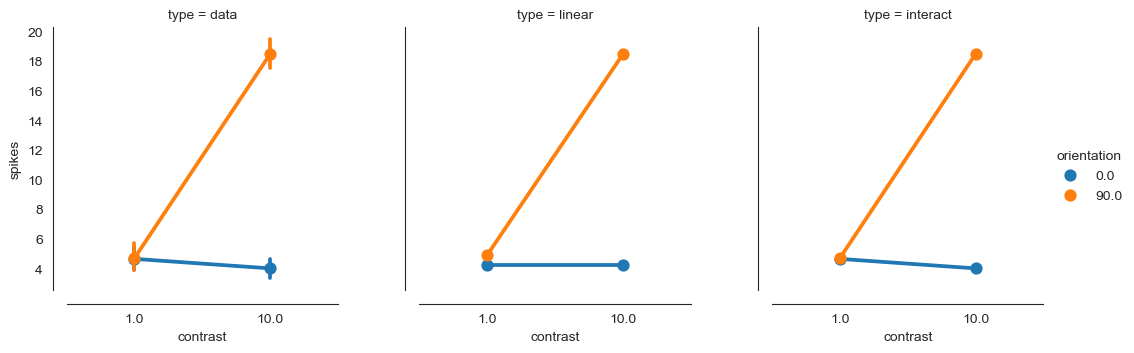

In [34]:
# build a new matrix with expand grid:
preds = expand_grid({'contrast': [1, 10], 'orientation': [0, 90]})  
preds_2 = preds.copy()

fit = smf.glm('spikes ~ contrast * orientation', 
              data=spk, 
              family=sm.families.Poisson()).fit()
preds['spikes'] = fit.predict(preds)


# also fit a model with no interaction for comparison:
# fit_2 = smf.glm('spikes ~ contrast * orientation', spk).fit()
fit_2 = smf.glm('spikes ~ contrast : orientation', data=spk, 
              family=sm.families.Poisson()).fit() # link=sm.families.links.log
preds_2['spikes'] = fit_2.predict(preds_2)

# to plot model predictions against data, we should merge them together:
# see answer (https://stackoverflow.com/questions/28239359/showing-data-and-model-predictions-in-one-plot-using-seaborn-and-statsmodels)
merged = pd.concat(dict(data=spk, 
                        linear=preds_2,
                        interact=preds),
                   names=['type']).reset_index()

g = sns.catplot(x='contrast', y='spikes', hue='orientation', 
                   data=merged, 
                   col='type',
                   kind='point',
                   height=3.5)
g.fig.subplots_adjust(wspace=0.3)
sns.despine(offset=10);

Note that this is particularly important if the counts are low, because than their non-negativity plays a role.

In [35]:
print(fit_2.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                 spikes   No. Observations:                  156
Model:                            GLM   Df Residuals:                      154
Model Family:                 Poisson   Df Model:                            1
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -376.09
Date:                Sun, 12 Feb 2023   Deviance:                       197.19
Time:                        17:53:57   Pearson chi2:                     187.
No. Iterations:                     5   Pseudo R-squ. (CS):             0.9799
Covariance Type:            nonrobust                                         
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept                1.4417 

In [36]:
# Do an expanded prediction for many contrasts, compare to linear model:

preds_3 = expand_grid({'contrast': np.linspace(0.01, 20), 'orientation': [0, 90]})  
preds_4 = preds_3.copy()

preds_3['yhat'] = fit.predict(preds_3)

fit_lm = smf.glm('spikes ~ contrast + orientation', data=spk).fit()
preds_4['yhat'] = fit_lm.predict(preds_3)

# to plot model predictions against data, we should merge them together:
# see answer (https://stackoverflow.com/questions/28239359/showing-data-and-model-predictions-in-one-plot-using-seaborn-and-statsmodels)
merged = pd.concat(dict(data=spk, 
                        poisson=preds_3,
                        linear=preds_4),
                   names=['type']).reset_index()

merged.tail()

,type,level_1,spikes,contrast,orientation,yhat
351,linear,95,NaN,19.184082,90.0,21.557336
352,linear,96,NaN,19.592041,0.0,14.598469
353,linear,97,NaN,19.592041,90.0,21.854879
354,linear,98,NaN,20.000000,0.0,14.896011
355,linear,99,NaN,20.000000,90.0,22.152422


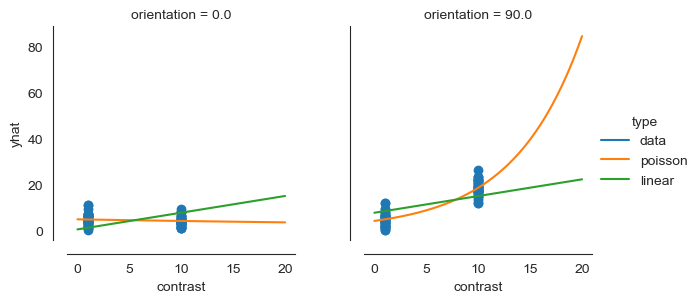

In [37]:
g = sns.FacetGrid(merged,
                  hue='type',
                  col='orientation')
g.map(plt.scatter, 'contrast', 'spikes')
g.map(plt.plot, 'contrast', 'yhat')
g.fig.subplots_adjust(wspace=0.3)
sns.despine(offset=10)
g.add_legend();


You can see that the linear and the poisson models give very different predictions outside the range of this data. Furthermore, the linear model 

- can predict negative rates
- assumes that variance homogenous, but for rate distributions (i.e. Poisson) the variance scales with the mean.

# Conclusion

The GLM allows us to specify different distributions for the response variable $y$ and for the link function $f()$. In this notebook we've considered two examples from the context of behavioural / neural science: percent correct data (binomial regression) and spiking data (poisson regression). The following table (adapted from John Kruschke's book, [*Doing Bayesian Data Analysis*](https://sites.google.com/site/doingbayesiandataanalysis/)) shows, for many types of response data, the appropriate error model and the most common link functions. 


Scale type of $y$ | Typical noise distribution of $y$ | Typical link function 
------------------| --------------------------------- | ---------------------
metric (continuous) | normal | identity
dichotomous (0 or 1) | bernoulli | logistic
nominal (unordered categories) | categorical | softmax
ordinal (ordered categories) | categorical | thresholded logistic
count | poisson | log

In this course, we've looked extensively at the first row, and touched on dichotomous and count data here. The GLM offers a powerful framework for modelling a wide variety of data.

